### Building predictive models

In this notebook we will apply predictive modelling using linear and tree based models. We will use statistics calculated previously as features to predict target variable.

Features are located in the data folder in _features.csv_.
Target is also located in the data folder in _target.csv_.

In [1]:
# First, we need to import some libraries and initialize Spark:

from os.path import join
import pandas as pd

import findspark
findspark.init('/home/alex/spark-2.4.3-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('modelling').getOrCreate()

from pyspark.sql.functions import concat, col, lit

# models, feature generators, cross validation, 
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.sql.functions import split
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

Now we import features and a target:

In [3]:
features = spark.read.csv(join('..','data','features.csv'), inferSchema=True, header=True)
target = spark.read.csv(join('..','data','target.csv'), inferSchema=True, header=True)

In [5]:
features.printSchema()

root
 |-- Batch: string (nullable = true)
 |-- EQ01_ST0_POWER_avg: double (nullable = true)
 |-- EQ01_ST0_POWER_max: double (nullable = true)
 |-- EQ01_ST0_POWER_min: double (nullable = true)
 |-- EQ01_ST0_POWER_std: double (nullable = true)
 |-- EQ01_ST0_POWER_weighted_avg: double (nullable = true)
 |-- EQ01_ST0_TEMP_avg: double (nullable = true)
 |-- EQ01_ST0_TEMP_max: double (nullable = true)
 |-- EQ01_ST0_TEMP_min: double (nullable = true)
 |-- EQ01_ST0_TEMP_std: double (nullable = true)
 |-- EQ01_ST0_TEMP_weighted_avg: double (nullable = true)
 |-- EQ02_ST0_POWER_avg: double (nullable = true)
 |-- EQ02_ST0_POWER_max: double (nullable = true)
 |-- EQ02_ST0_POWER_min: double (nullable = true)
 |-- EQ02_ST0_POWER_std: double (nullable = true)
 |-- EQ02_ST0_POWER_weighted_avg: double (nullable = true)
 |-- EQ02_ST0_TEMP_avg: double (nullable = true)
 |-- EQ02_ST0_TEMP_max: double (nullable = true)
 |-- EQ02_ST0_TEMP_min: double (nullable = true)
 |-- EQ02_ST0_TEMP_std: double (nullabl

In [6]:
target.printSchema()

root
 |-- Batch: string (nullable = true)
 |-- Target: double (nullable = true)



Let's see how many rows with missings we have in features table:

In [7]:
print("Number of rows with missings = ",features.count()-features.na.drop().count())

Number of rows with missings =  1


We will remove this record merge features with the target and transform with a vector assembler.

In [8]:
# drop records with missings
features = features.na.drop()

# merge target
data = features.join(target, on=['Batch']).withColumnRenamed('Target', 'label')

# assemble features 
inputCols = features.columns[1:]
assembler = VectorAssembler(inputCols=inputCols, outputCol='features')
data = assembler.transform(data)

data.select(['features','label']).show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[1.16738448490533...| 3.444484710612145|
|[105.159845039003...|3.5485890281002694|
|[9.37172795534053...| 3.084613334650707|
|[51.6581743706699...| 6.414245313635492|
|[13.1270189942734...| 5.966605373052227|
+--------------------+------------------+
only showing top 5 rows



Let's start with a linear model and 80/20 train/test split.

In [9]:
# 80/20 split
train, test = data.randomSplit([0.8, 0.2], seed=0)

# building models
lr = LinearRegression()
model = lr.fit(train)

# model evaluators
eval_rmse = RegressionEvaluator(metricName="rmse")
eval_r2 = RegressionEvaluator(metricName="r2")

def print_quality(model):
    print("Train/Test RMSE: {} / {}".format(round(eval_rmse.evaluate(model.transform(train)),2),\
                                            round(eval_rmse.evaluate(model.transform(test)),2)))
    print("Train/Test R_squared: {} / {}".format(round(eval_r2.evaluate(model.transform(train)),2),
                                                 round(eval_r2.evaluate(model.transform(test)),2)))
    
print_quality(model)

Train/Test RMSE: 0.29 / 0.4
Train/Test R_squared: 0.96 / 0.91


We can tune parameters with 5 folds cross-validation:

In [10]:
lr = LinearRegression(maxIter=5)

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.1,0.01])\
                              .addGrid(lr.elasticNetParam,[0,1]).build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval_rmse,
                          numFolds=5)

cvModel = crossval.fit(train)

print_quality(cvModel)

Train/Test RMSE: 0.31 / 0.39
Train/Test R_squared: 0.95 / 0.91


We can also try tree-based models: 

In [11]:
rf = RandomForestRegressor(numTrees=10)

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth,[1,5,10,15])\
                              .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval_rmse,
                          numFolds=5)

cvModel = crossval.fit(train)
print_quality(cvModel)

Train/Test RMSE: 0.37 / 0.86
Train/Test R_squared: 0.93 / 0.56


Linear model performs better. Let's look at the features. For convenience we will go for that with pandas :)

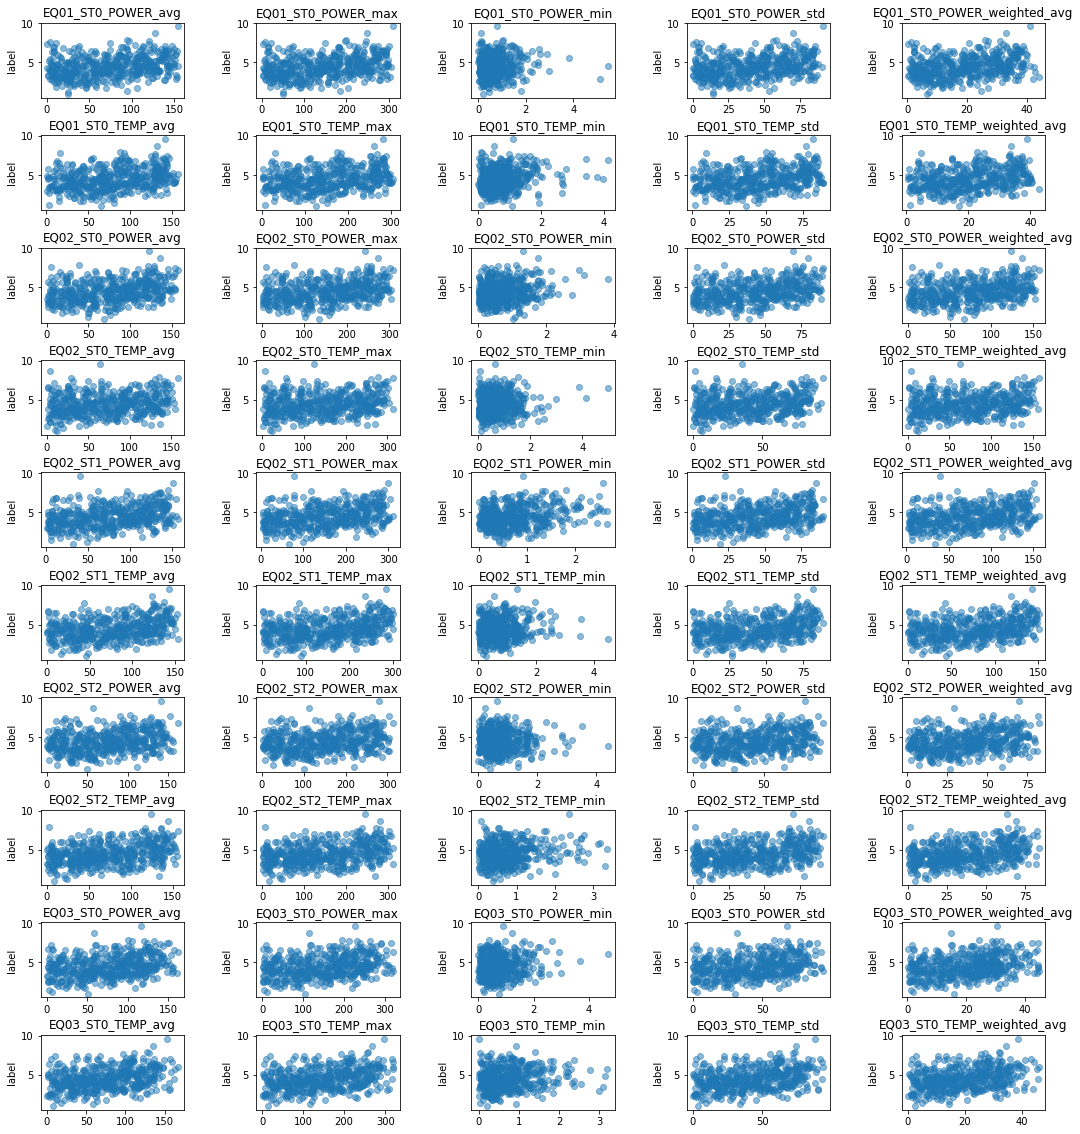

In [12]:
data_pd = data.toPandas().drop(['features'], axis=1)
columns = data_pd.columns[1:-1]

fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(1, 51):
    f = columns[i-1]
    plt.subplot(10, 5, i)
    plt.scatter(data_pd[f], data_pd['label'], alpha=0.5)
    plt.title(f)
    plt.ylabel('label')
plt.show()

Features corresponding to the same equipment and status (same row) seem to be very similar. Let's compute correlations.

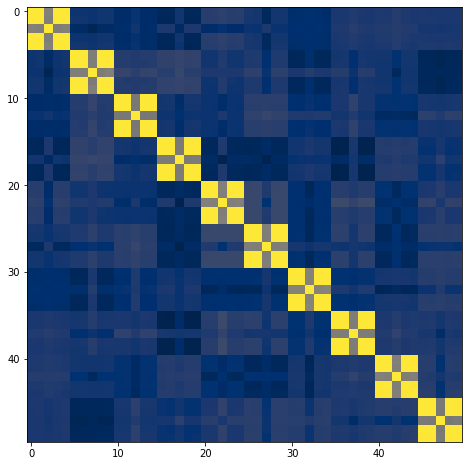

In [13]:
plt.figure(figsize=(8,8))
correlation_matrix = data_pd[columns].corr().values
plt.imshow(correlation_matrix,cmap='cividis',interpolation='nearest')
plt.show()

This means that min, max, avg and weighted_avg are highly correlated and we can leave only one feature from them. We'll leave weighted_avg.

In [14]:
# assemble features only std and weighted_avg
inputCols = [f for f in features.columns[1:] if 'std' in f or 'weighted_avg' in f]
assembler = VectorAssembler(inputCols=inputCols, outputCol='features_reduced')
data = assembler.transform(data)

data.select(['features_reduced','label']).show(5)

+--------------------+------------------+
|    features_reduced|             label|
+--------------------+------------------+
|[0.49222200458969...| 3.444484710612145|
|[59.7118780167508...|3.5485890281002694|
|[5.12531488130129...| 3.084613334650707|
|[29.6576263275977...| 6.414245313635492|
|[7.21125361811843...| 5.966605373052227|
+--------------------+------------------+
only showing top 5 rows



Let's look at the impact on linear model:

In [15]:
# 80/20 split
train, test = data.randomSplit([0.8, 0.2], seed=0)

# building models
lr = LinearRegression(featuresCol='features_reduced')
model = lr.fit(train)

In [16]:
print_quality(model)

Train/Test RMSE: 0.32 / 0.38
Train/Test R_squared: 0.95 / 0.92


Because we have less features we can now add second order features. Previously it might cause overfitting.

In [17]:
# add second order features
polyExpansion = PolynomialExpansion(degree=2, inputCol="features_reduced", outputCol="features_second_order")
data = polyExpansion.transform(data)

# 80/20 split
train, test = data.randomSplit([0.8, 0.2], seed=0)

# building models
lr = LinearRegression(featuresCol='features_second_order')
model = lr.fit(train)

In [18]:
print_quality(model)

Train/Test RMSE: 0.07 / 0.22
Train/Test R_squared: 1.0 / 0.97


We should see all the points laying along the diagonal on predicted vs actual plot.

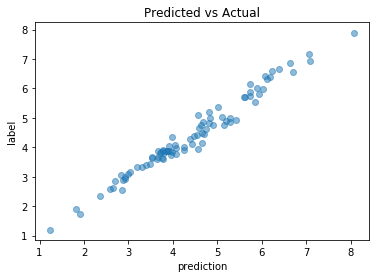

In [19]:
result = model.transform(test).select(['label','prediction']).toPandas()

plt.scatter(result['prediction'], result['label'], alpha=0.5)
plt.title('Predicted vs Actual')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

Great! We have nearly perfect predictions.